In [2]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [3]:
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import classification_common
import joblib

#To ensure reproducibility
np.random.seed(39)

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

In [5]:
# Create/store/load binary image data
if not os.path.isfile(DATA_DIR + 'binary_imgs.npy'):

    dataset_path = "../../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
    img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
    img_filenames.sort()
    print('Number of subjects: %d' % len(img_filenames))

    img_shape = load_img(img_filenames[0]).shape

    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
    masker = masker.fit()

    imgs = masker.transform(img_filenames) # break down into slices if necessary
    imgs = imgs.astype(bool)
    np.save(DATA_DIR + 'binary_imgs', imgs)

else:
    imgs = np.load(DATA_DIR + 'binary_imgs.npy')

print(imgs.shape)

(1401, 228453)


In [5]:
# Calculate/load 100 PC components
N_PCA = 100
if not os.path.isfile(DATA_DIR + 'binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=N_PCA, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save(DATA_DIR + 'binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load(DATA_DIR + 'binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [6]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


#### 1- Logistic Regression

In [11]:
def run_logistic_regression_clf(X, Y_sort_idx, print_best_params=True):
    
    estimator = LogisticRegression(random_state = 39, max_iter=20000)
    C = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000] # C = np.logspace(-1, 10, 12)
    grid = {'C': C}
    
    return classification_common.run_classification(X, Y_sort_idx,estimator, grid, "Logistic Regression", 
                                                    print_best_params=print_best_params)


In [17]:
REPEAT_FOLDS = 5

scores_lr_all = pd.DataFrame()
best_params_lr_all = pd.DataFrame()

rs = np.random.RandomState(39)

for it in range(REPEAT_FOLDS):
    
    shuffle_idx = rs.choice(np.arange(Y.shape[0]), Y.shape[0], replace=False)
    
    X_shuffled = X_pc[shuffle_idx]
    Y_shuffled = Y[shuffle_idx]
    
    Y_sort_idx = np.empty(Y.shape, dtype=int)
    for i in range(Y.shape[1]):
        Y_sort_idx[:, i] = np.argsort(Y_shuffled[:, i])
#     print(Y_sort_idx)

    scores_df_lr, best_params_df_lr = run_logistic_regression_clf(X_shuffled, Y_sort_idx, print_best_params=False)
    
    scores_df_lr["Iteration"] = it+1
    best_params_df_lr["Iteration"] = it+1
    
    scores_lr_all = pd.concat([scores_lr_all, scores_df_lr], ignore_index=True)
    best_params_lr_all = pd.concat([best_params_lr_all, best_params_df_lr], ignore_index=True)
    
    print("\nIteration " + str(it+1) + " Completed.\n")
    
    


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn


Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn


Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Information Processing Speed

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Executive Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Iteration 1 Completed.


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Information Processing Speed

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Executive Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Iteration 2 Completed.


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn


Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Information Processing Speed

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Executive Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Iteration 3 Completed.


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Information Processing Speed

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Executive Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Iteration 4 Completed.


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn


Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Information Processing Speed

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Executive Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Iteration 5 Completed.



#### 2- Random Forest

In [20]:
def run_random_forest_clf(X, Y_sort_idx, print_best_params=True):
    
    estimator = RandomForestClassifier(random_state = 39)
    
    n_estimators = [100, 300, 500, 700, 900, 1100, 1300]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [5, 10, 20, 30, 40, 50, 60, 70, 100, None]
    min_samples_split = [2, 5, 7, 10, 12, 15, 18, 20]
    min_samples_leaf = [1, 2, 3, 4]
    max_samples = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9, None]
    
    grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

    
    return classification_common.run_classification(X, Y_sort_idx, estimator, grid, "Random Forest", 
                                                    random_search_cv=True, print_best_params=print_best_params)
    

In [21]:
REPEAT_FOLDS = 5

scores_rf_all = pd.DataFrame()
best_params_rf_all = pd.DataFrame()

rs = np.random.RandomState(39)

for it in range(REPEAT_FOLDS):
    
    shuffle_idx = rs.choice(np.arange(Y.shape[0]), Y.shape[0], replace=False)
    
    X_shuffled = X_pc[shuffle_idx]
    Y_shuffled = Y[shuffle_idx]
    
    Y_sort_idx = np.empty(Y.shape, dtype=int)
    for i in range(Y.shape[1]):
        Y_sort_idx[:, i] = np.argsort(Y_shuffled[:, i])

    scores_df_rf, best_params_df_rf = run_random_forest_clf(X_shuffled, Y_sort_idx, print_best_params=False)
    
    scores_df_rf["Iteration"] = it+1
    best_params_df_rf["Iteration"] = it+1
    
    scores_rf_all = pd.concat([scores_rf_all, scores_df_rf], ignore_index=True)
    best_params_rf_all = pd.concat([best_params_rf_all, best_params_df_rf], ignore_index=True)
    
    print("\nIteration " + str(it+1) + " Completed.\n")
    
    


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Information Processing Speed

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Executive Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Iteration 1 Completed.


Global Cognition

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Language

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Visuospatial Functioning

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Memory

Data % used: 100.0%
Data % used: 60.0%
Data % used: 40.0%
Data % used: 20.0%

Information Proce

#### Plot results

In [34]:
scores_all = pd.concat([scores_lr_all, scores_rf_all], ignore_index=True)

# persist results
scores_all.to_hdf('results/results_pca_100_single_output_sensitivity.h5', key='p', mode='w')
# scores_all = pd.read_hdf('results/results_pca_100_single_output_sensitivity.h5', key='p', mode='r')

In [57]:
import seaborn as sns
def plot_scores(score_df, score_type, hue_order=None, agg_type=''):

    data = score_df[(score_df["Score type"] == score_type)]

    palette = {"Logistic Regression": "C0", "Random Forest": "C2", "Neural Network": "C4", "XGBoost": "C3"}

    g = sns.catplot(x="Domain", y="Score", hue="Model", col="% Data", row="Metric",
                    data=data, ci="sd", kind="bar", palette=palette, hue_order=hue_order,
                   row_order=["Accuracy", "AUC"], order=['Global Cognition', 'Language', 'Visuospatial Functioning', 'Memory',
                 'Information Processing Speed', 'Executive Functioning'], height=7)

    g.set_axis_labels("", "Mean and Standard Deviation of the " + agg_type + " SCORE OF THE 5 CV FOLDS across iterations")
#     g.set(ylim=(0, 0.85))
    
    for i, ax in enumerate(g.fig.axes):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
        ax.axhline(0.5, color="black")

    g.fig.suptitle(agg_type + " score of folds across iterations (with random shuffling): " + score_type, y=1.08, fontsize=30)
    
#     if score_type =="Out-of-sample":
#         g.savefig("results/fig/" + agg_type)

def plot_all_scores(score_df, hue_order=None, agg_type=None):
    plot_scores(score_df, "Out-of-sample", hue_order=hue_order, agg_type=agg_type)
    plot_scores(score_df, "In-sample", hue_order=hue_order, agg_type=agg_type)


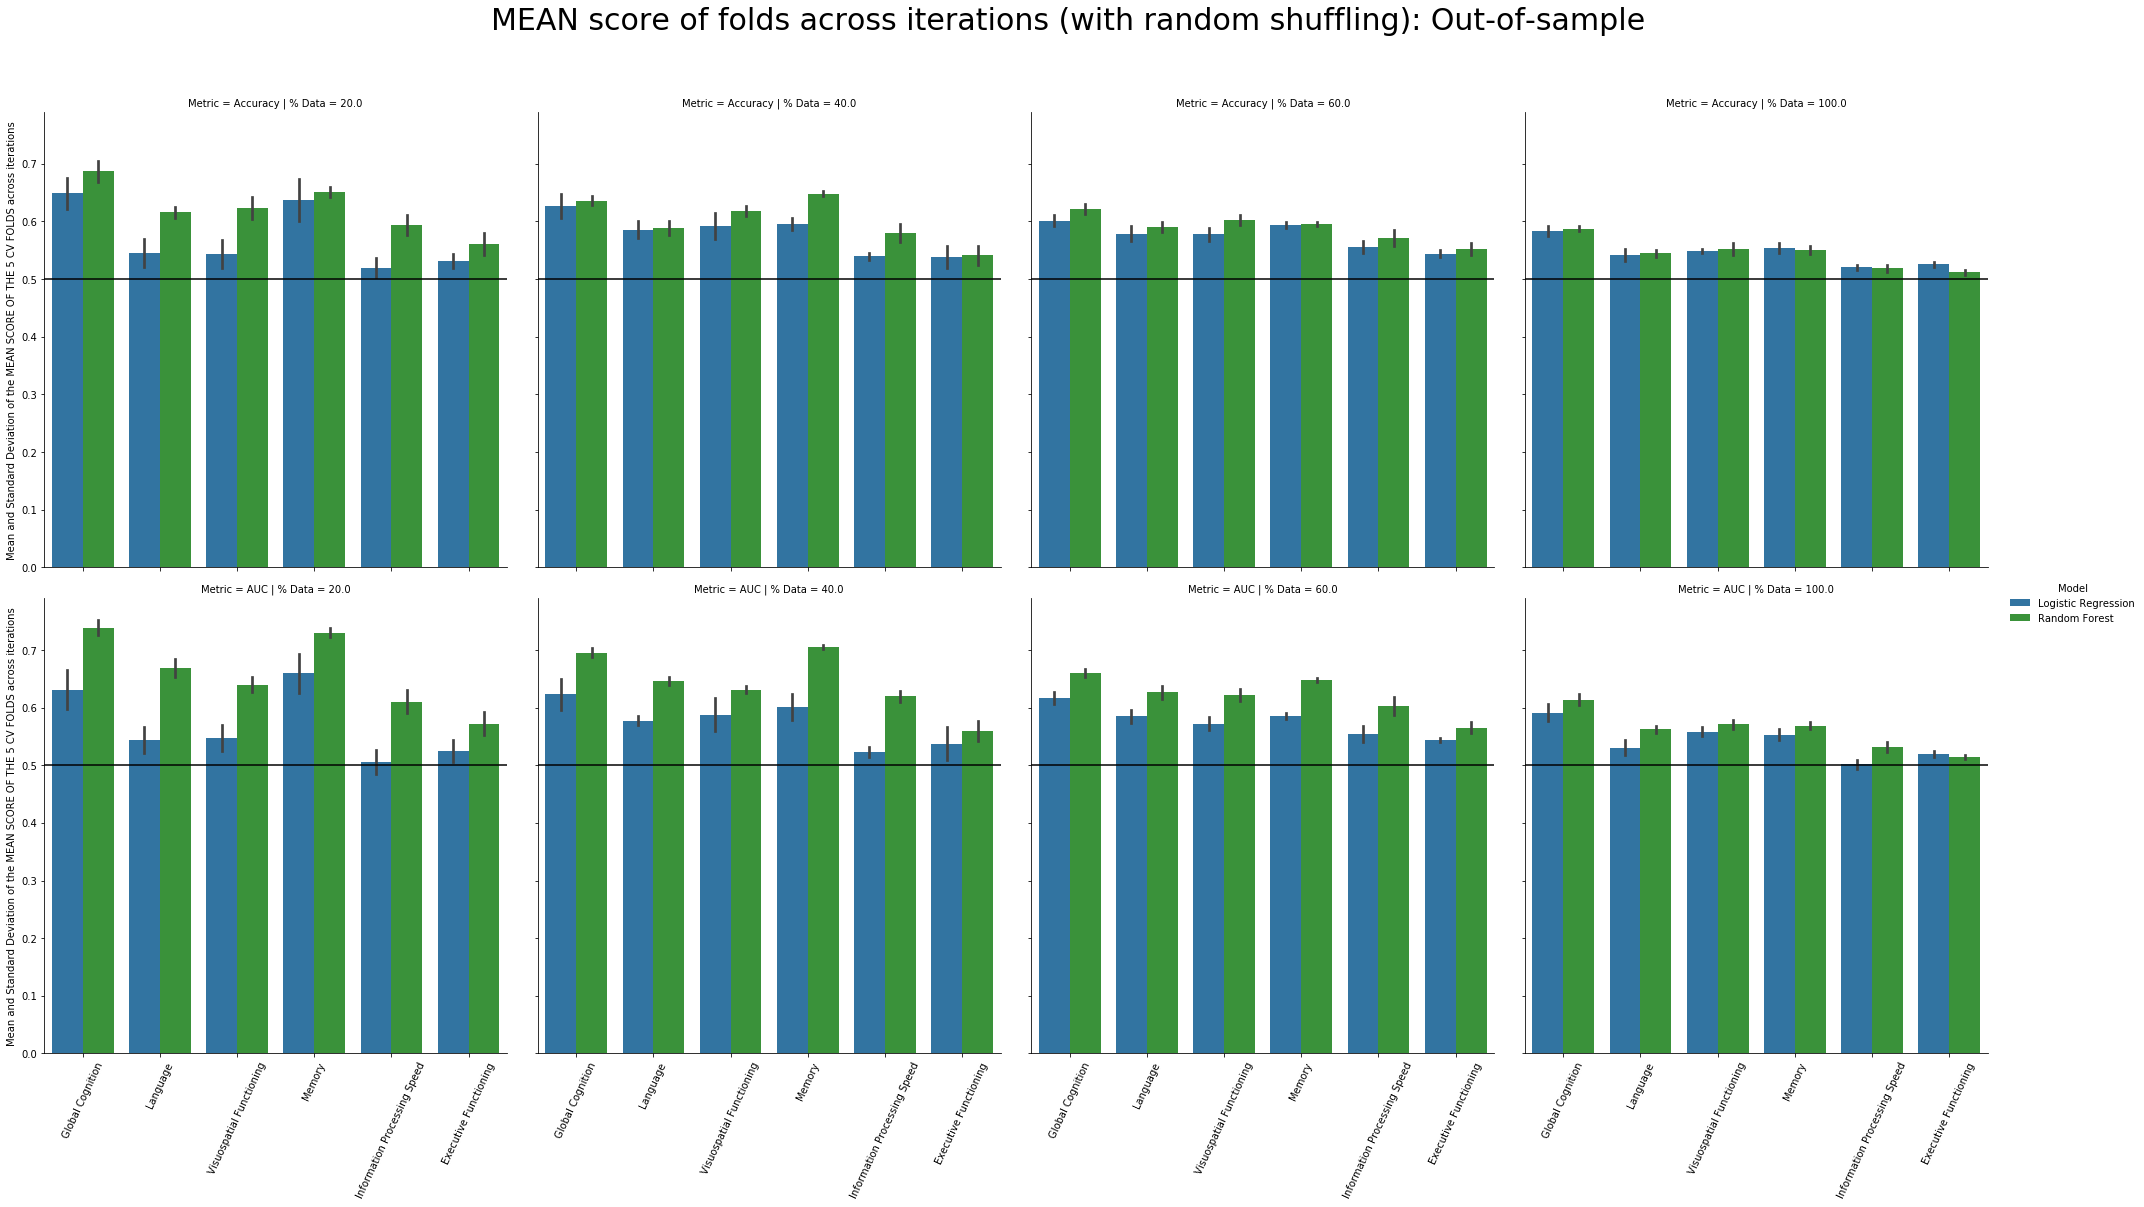

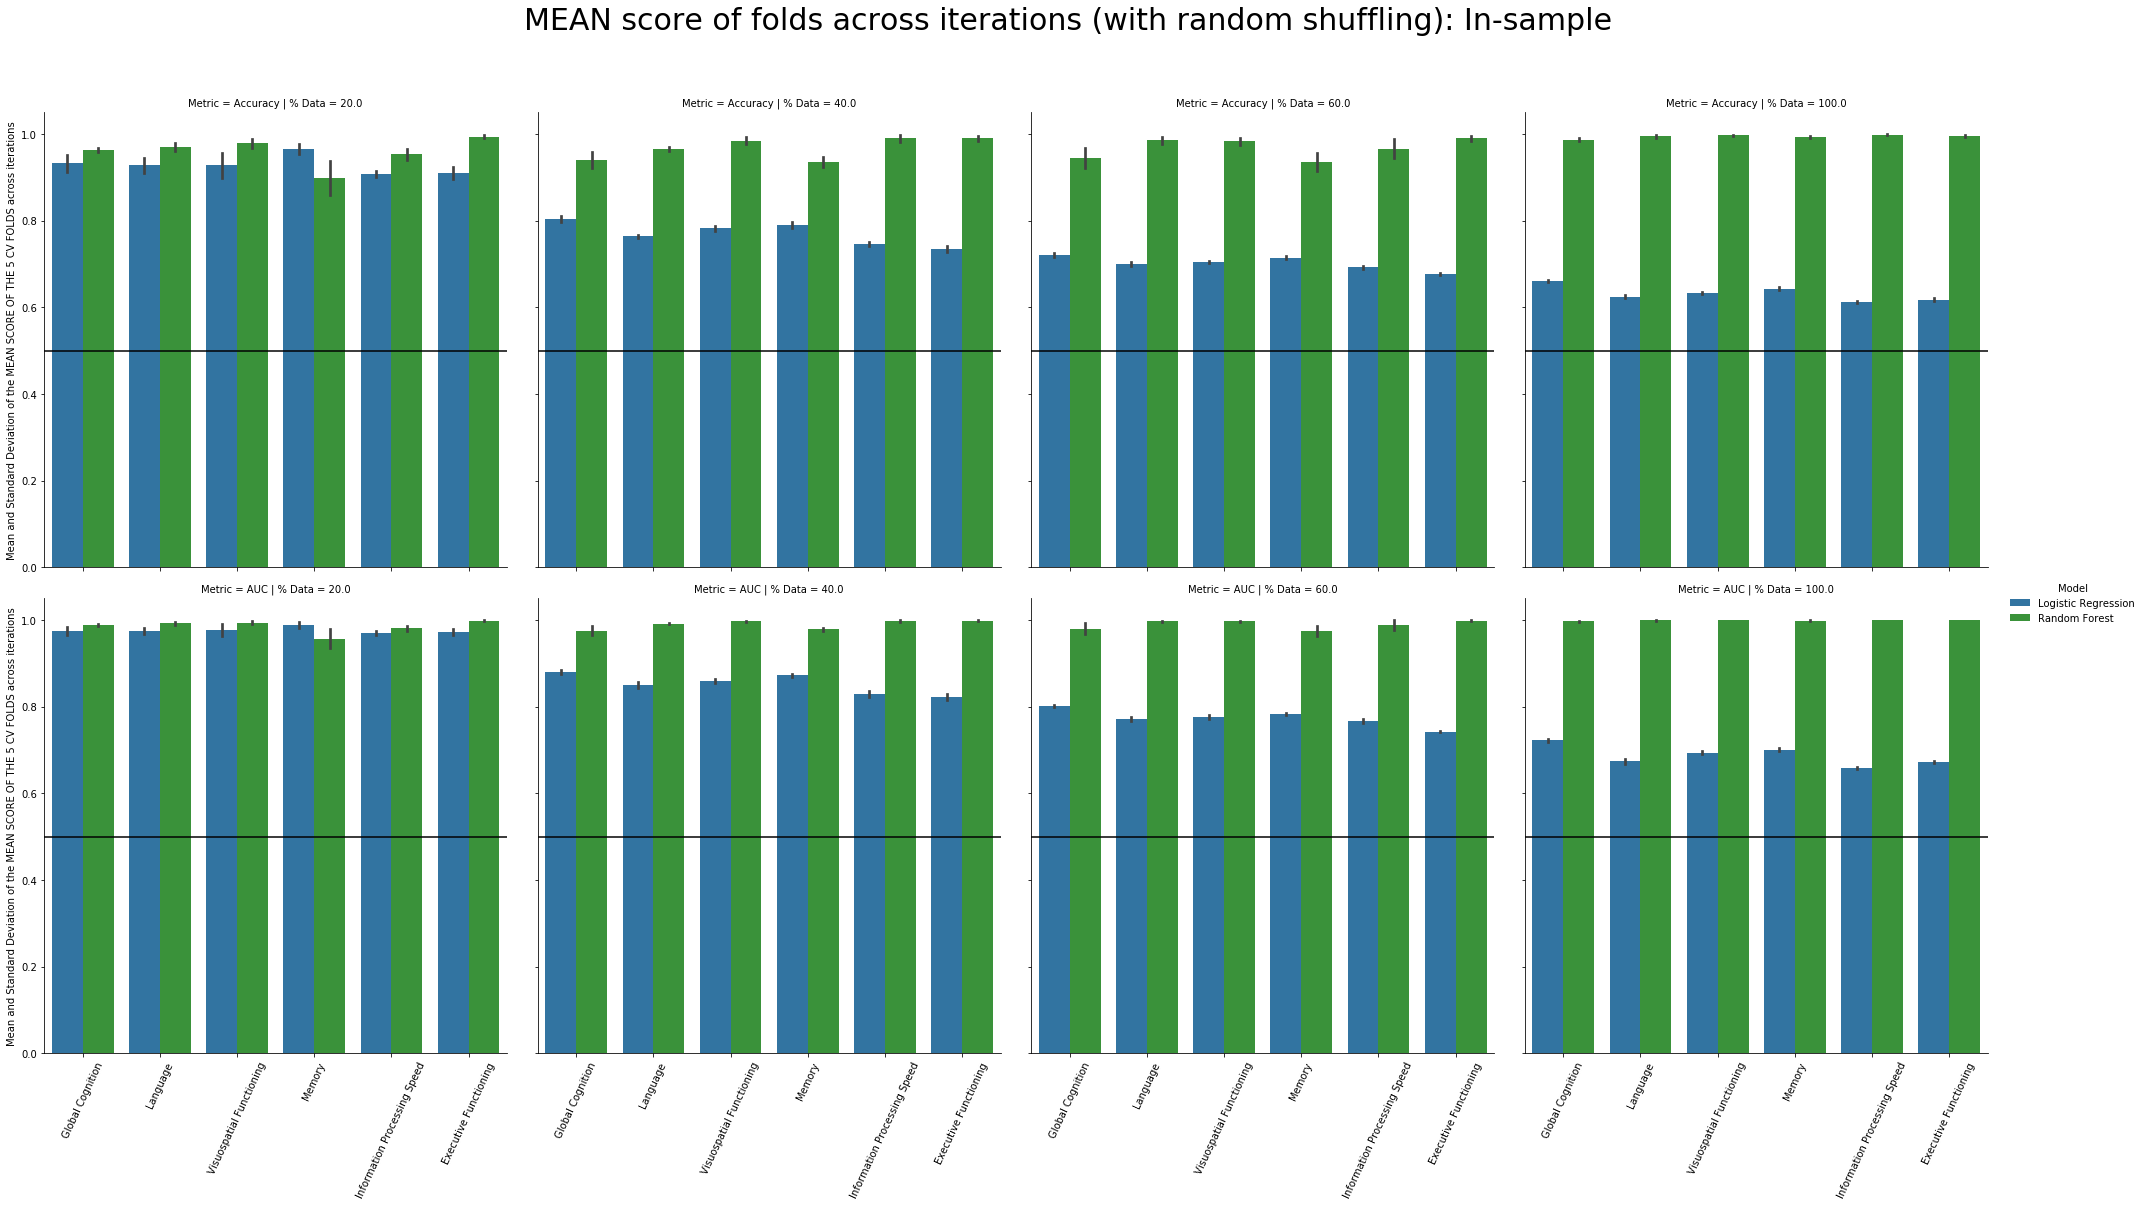

In [58]:
# average scores across all 5 folds to get one number for each iteration

scores_avg_fold = scores_all.groupby(['Model', '% Data', 'Domain', 'Metric', 'Score type', 'Iteration'])\
                               .agg({'Score': ['mean']}).reset_index()
scores_avg_fold.columns = scores_avg_fold.columns.get_level_values(0)

plot_all_scores(scores_avg_fold, agg_type="MEAN")

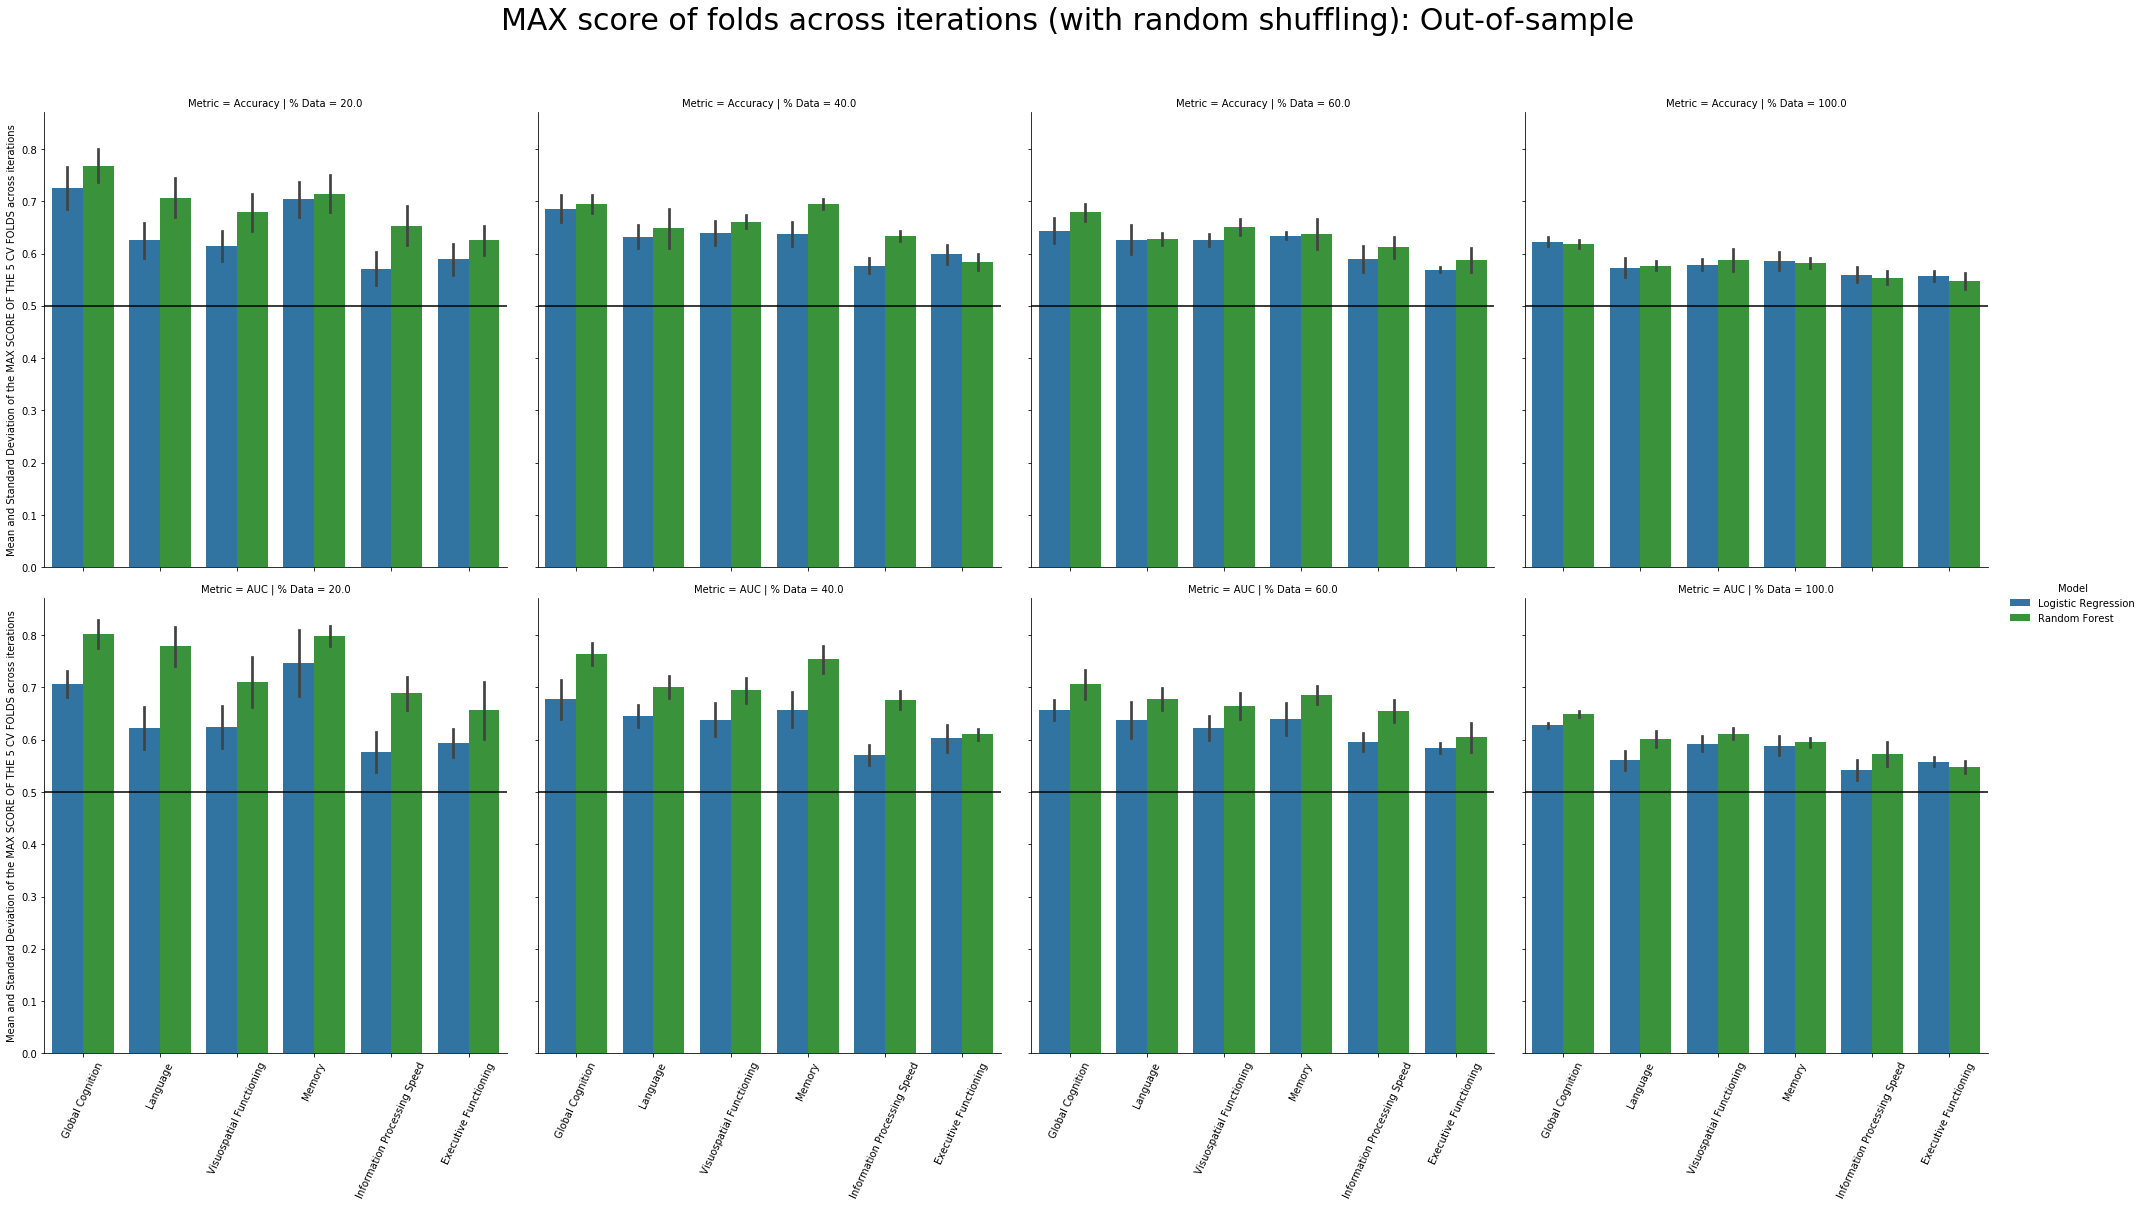

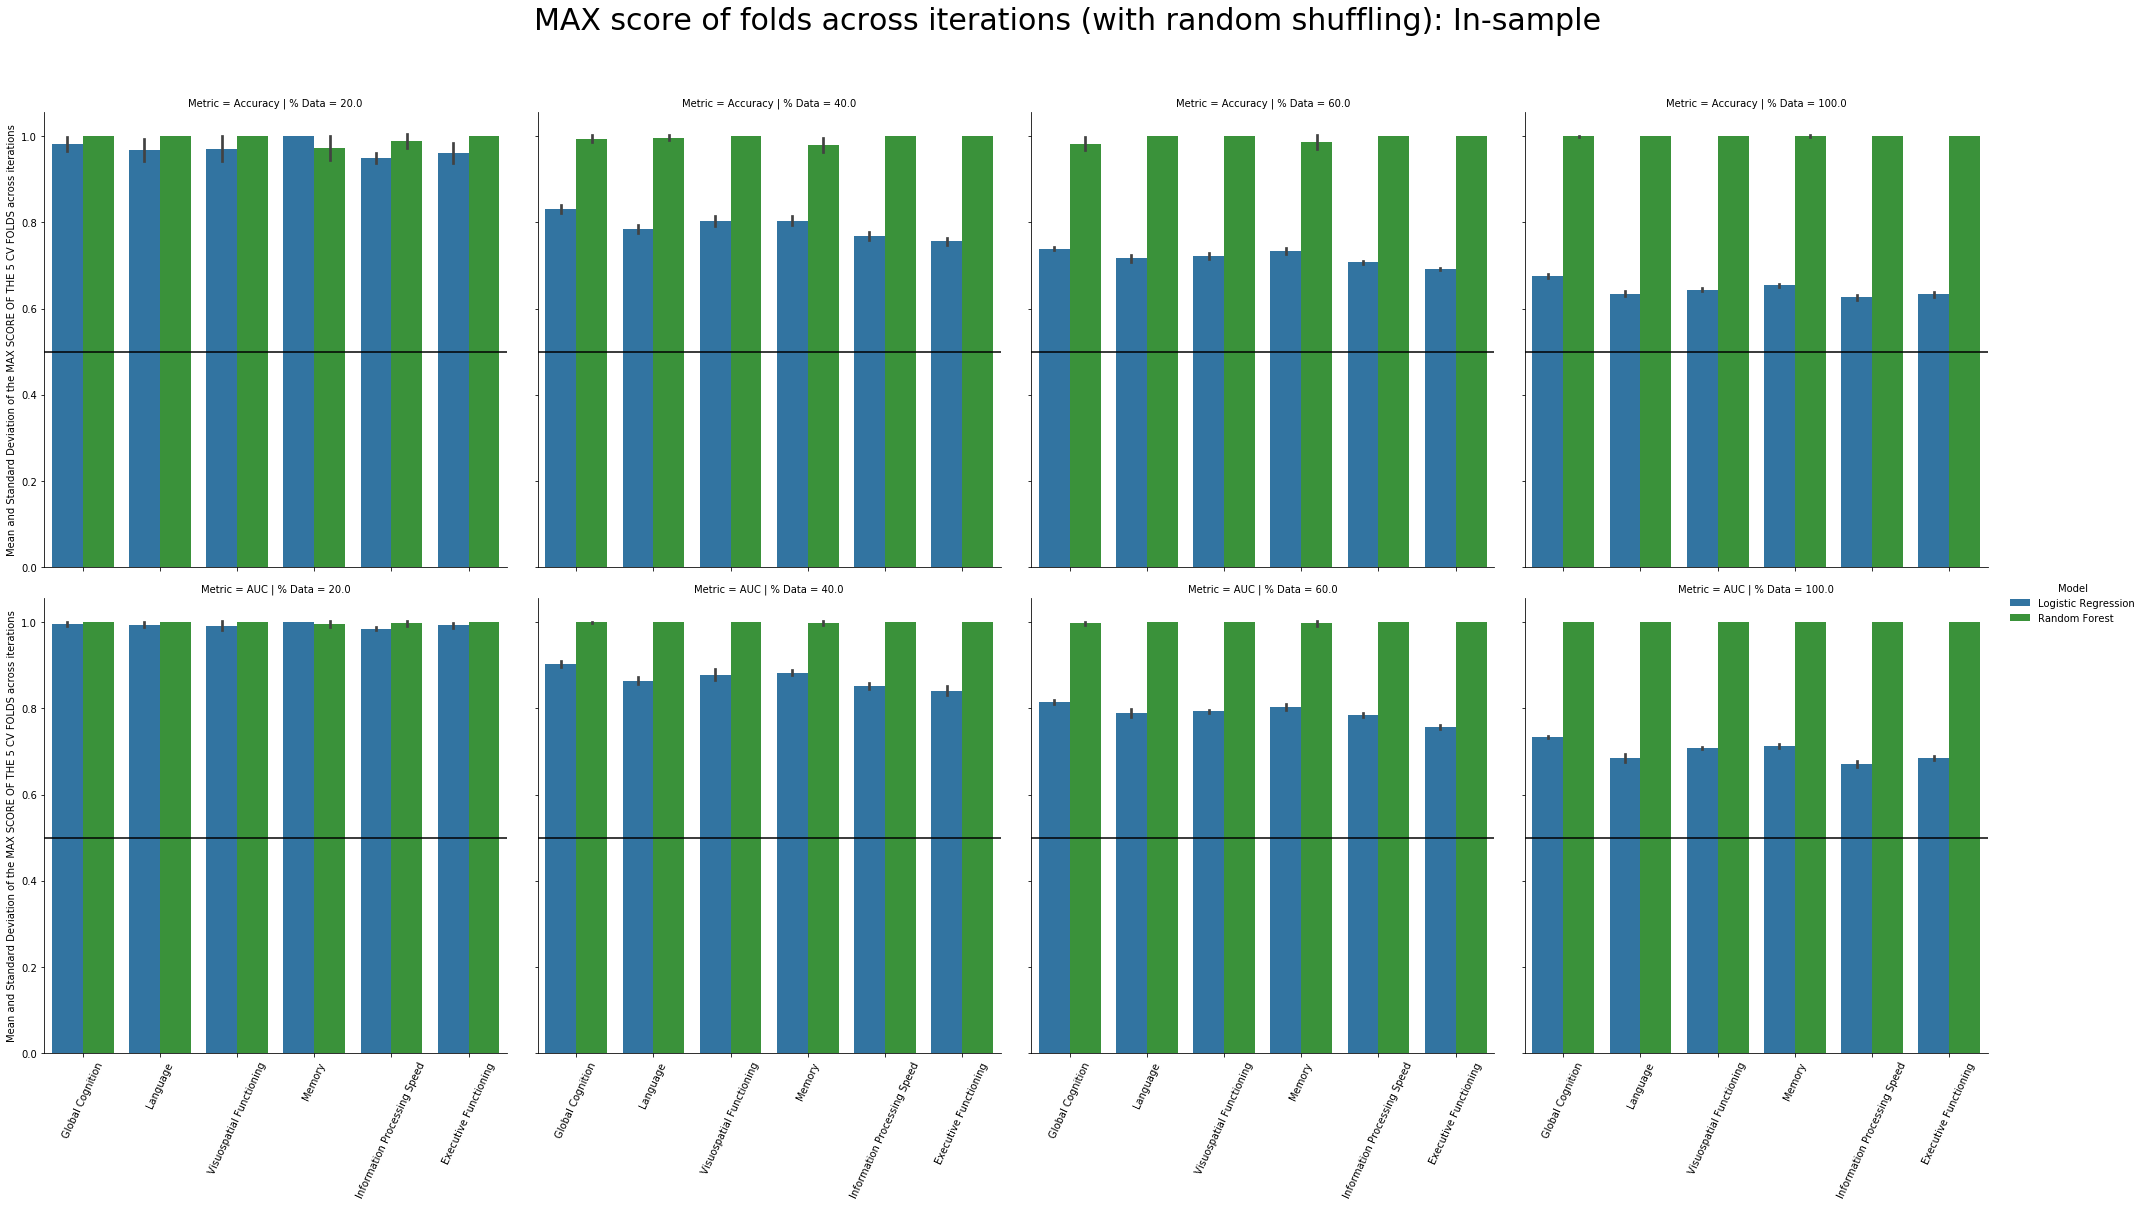

In [59]:
# take the max score of all 5 folds to get one number for each iteration

scores_max_fold = scores_all.groupby(['Model', '% Data', 'Domain', 'Metric', 'Score type', 'Iteration'])\
                               .agg({'Score': ['max']}).reset_index()
scores_max_fold.columns = scores_max_fold.columns.get_level_values(0)

plot_all_scores(scores_max_fold, agg_type="MAX")